In [2]:
# Setup & Imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import pandas as pd
import os, random

print(f"TensorFlow: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU: {gpus[0].name}" if gpus else "No GPU")

np.random.seed(42); tf.random.set_seed(42); random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)

TensorFlow: 2.20.0
No GPU


In [4]:
# Load Dataset
# Dataset is pre-split into train/ and test/.
# Validation is cut from train (80/20).

IMG_SIZE = 128
BATCH_SIZE = 32
DATA_DIR = '../data'   # change to '../data' if notebook is inside a subfolder

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    validation_split=0.2,
    subset='training',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'train'),
    validation_split=0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical'
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, 'test'),
    seed=42,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=False
)

CLASS_NAMES = train_ds.class_names
NUM_CLASSES = len(CLASS_NAMES)

print(f"Train classes: {train_ds.class_names}")
print(f"Test  classes: {test_ds.class_names}")
print(f"NUM_CLASSES: {NUM_CLASSES}")

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 31708 files belonging to 3 classes.
Using 25367 files for training.
Found 31708 files belonging to 3 classes.
Using 6341 files for validation.
Found 9446 files belonging to 3 classes.
Train classes: ['Smoke', 'fire', 'non fire']
Test  classes: ['Smoke', 'fire', 'non fire']
NUM_CLASSES: 3


Train set:
  Smoke: 10108 images
  fire: 10798 images
  non fire: 10800 images

Test set:
  Smoke: 2446 images
  fire: 3500 images
  non fire: 3500 images


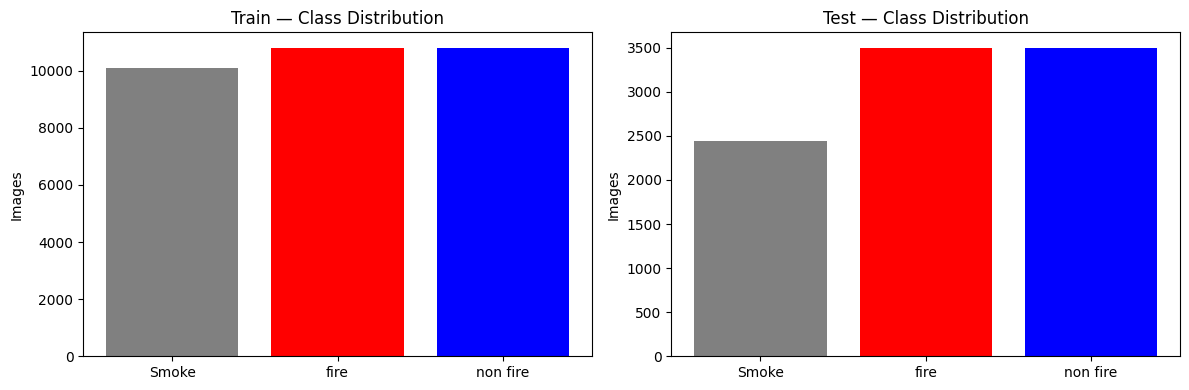


 Imbalance ratio (train): 1.07x (max=10800, min=10108)


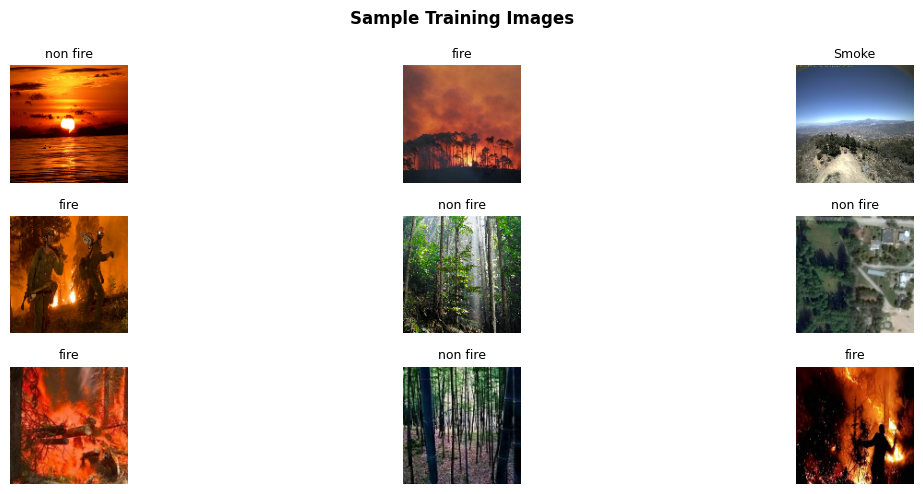


Batch shape : (32, 128, 128, 3)
Pixel range : [0, 255]
Single image: (128, 128, 3)
Flattened   : 49,152 features — why CNNs matter!


In [6]:
# Data Exploration
# Count images per class and check for imbalance
counts_train = {}
counts_test  = {}

for cls in CLASS_NAMES:
    train_path = os.path.join(DATA_DIR, 'train', cls)
    test_path  = os.path.join(DATA_DIR, 'test',  cls)
    counts_train[cls] = len([f for f in os.listdir(train_path)
                              if f.lower().endswith(('.jpg','.jpeg','.png'))])
    counts_test[cls]  = len([f for f in os.listdir(test_path)
                              if f.lower().endswith(('.jpg','.jpeg','.png'))])

print("Train set:")
for cls, n in counts_train.items():
    print(f"  {cls}: {n} images")
print("\nTest set:")
for cls, n in counts_test.items():
    print(f"  {cls}: {n} images")

# Class distribution bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].bar(counts_train.keys(), counts_train.values(), color=['gray','red','blue'])
axes[0].set_title('Train — Class Distribution'); axes[0].set_ylabel('Images')
axes[1].bar(counts_test.keys(), counts_test.values(), color=['gray','red','blue'])
axes[1].set_title('Test — Class Distribution'); axes[1].set_ylabel('Images')
plt.tight_layout(); plt.show()

max_c = max(counts_train.values())
min_c = min(counts_train.values())
print(f"\n Imbalance ratio (train): {max_c/min_c:.2f}x "
      f"(max={max_c}, min={min_c})")

# Sample images
plt.figure(figsize=(14, 5))
for images, labels in train_ds.take(1):
    for i in range(min(9, len(images))):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(CLASS_NAMES[np.argmax(labels[i])], fontsize=9)
        plt.axis('off')
plt.suptitle('Sample Training Images', fontweight='bold')
plt.tight_layout(); plt.show()

# Image properties
for images, _ in train_ds.take(1):
    print(f"\nBatch shape : {images.shape}")
    print(f"Pixel range : [{images.numpy().min():.0f}, {images.numpy().max():.0f}]")
    print(f"Single image: {images[0].shape}")
    print(f"Flattened   : {IMG_SIZE*IMG_SIZE*3:,} features — why CNNs matter!")

In [24]:
# Helper Functions
def plot_training_curves(history, title='Model'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    ax1.plot(history.history['accuracy'],     label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Val',   linewidth=2)
    ax1.set_title(f'{title} — Accuracy', fontweight='bold')
    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
    ax1.legend(); ax1.grid(True, alpha=0.3)

    ax2.plot(history.history['loss'],     label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Val',   linewidth=2)
    ax2.set_title(f'{title} — Loss', fontweight='bold')
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
    ax2.legend(); ax2.grid(True, alpha=0.3)
    plt.tight_layout(); plt.show()

    train_acc = history.history['accuracy'][-1]
    val_acc   = max(history.history['val_accuracy'])   # use best val, not last
    gap = train_acc - val_acc
    print(f"\nFinal Train Acc : {train_acc:.4f}")
    print(f"Best  Val   Acc : {val_acc:.4f}")
    print(f"Gap             : {gap:.4f}")
    if gap > 0.15:   print(" Overfitting")
    elif gap > 0.05: print(" Some overfitting")
    else:            print(" Good generalization")

def evaluate_model(model, dataset, name='Model'):
    y_true, y_pred = [], []
    for images, labels in dataset:
        preds = model.predict(images, verbose=0)
        y_true.extend(np.argmax(labels.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))
    print(f"\n{name} — Classification Report:")
    print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, cmap='Blues')
    plt.title(f'{name} — Confusion Matrix', fontweight='bold')
    plt.colorbar()
    ticks = np.arange(NUM_CLASSES)
    plt.xticks(ticks, CLASS_NAMES, rotation=45)
    plt.yticks(ticks, CLASS_NAMES)
    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j] > cm.max()/2 else 'black')
    plt.tight_layout(); plt.show()
    return y_true, y_pred

print(" Helper functions loaded")

 Helper functions loaded


In [25]:
# Baseline CNN — Build (No Augmentation)
model_basic = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Conv Block 1
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    # Conv Block 2
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    # Conv Block 3
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),
    # Classification head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model_basic.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_basic.summary()

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 155s 195ms/step - accuracy: 0.9943 - loss: 0.0158 - val_accuracy: 0.9595 - val_loss: 0.2582
Epoch 2/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 149s 188ms/step - accuracy: 0.9942 - loss: 0.0167 - val_accuracy: 0.9663 - val_loss: 0.2488
Epoch 3/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 320s 404ms/step - accuracy: 0.9939 - loss: 0.0179 - val_accuracy: 0.9642 - val_loss: 0.2970
Epoch 4/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 152s 192ms/step - accuracy: 0.9935 - loss: 0.0201 - val_accuracy: 0.9633 - val_loss: 0.2626
Epoch 5/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 148s 187ms/step - accuracy: 0.9939 - loss: 0.0177 - val_accuracy: 0.9628 - val_loss: 0.3455
Epoch 6/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 153s 193ms/step - accuracy: 0.9953 - loss: 0.0121 - val_accuracy: 0.9633 - val_loss: 0.2986
Epoch 7/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 157s 198ms/step - accuracy: 0.9946 - loss: 0.0148 - val_accuracy: 0.9672 - val_loss: 0.2754
Epoch 8/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 153s 193ms/step - accuracy: 0.9946 -

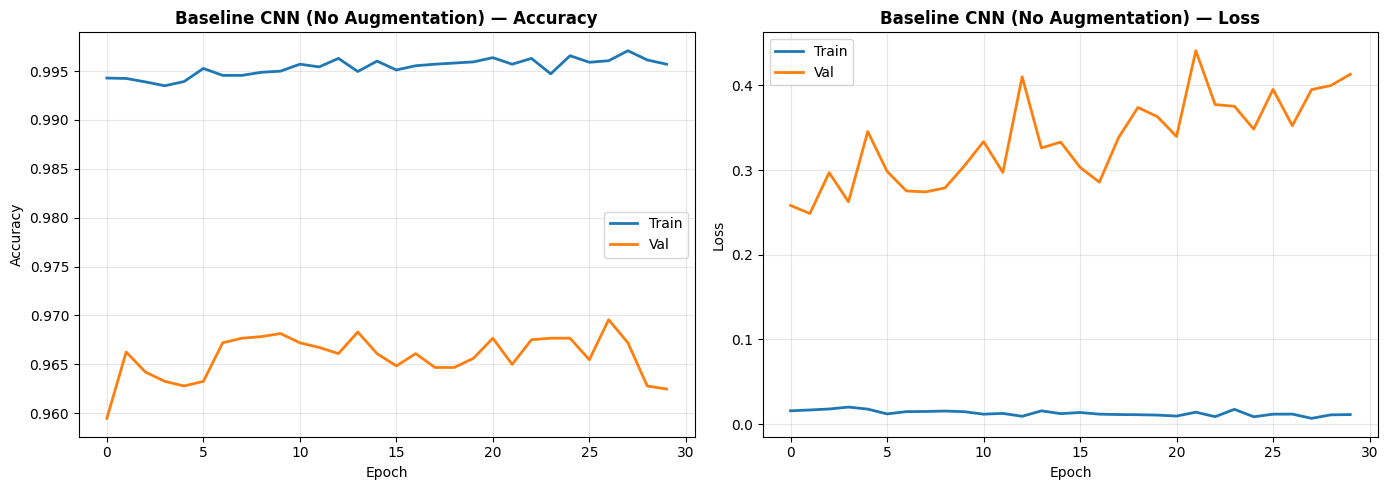


Final Train Acc : 0.9957
Best  Val   Acc : 0.9696
Gap             : 0.0261
 Good generalization


In [10]:
# Baseline CNN — Train
EPOCHS = 30
history_basic = model_basic.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
plot_training_curves(history_basic, title='Baseline CNN (No Augmentation)')


Baseline CNN (Val) — Classification Report:
              precision    recall  f1-score   support

       Smoke       0.00      0.00      0.00      1934
        fire       0.33      0.96      0.50      2156
    non fire       0.29      0.01      0.01      2251

    accuracy                           0.33      6341
   macro avg       0.21      0.32      0.17      6341
weighted avg       0.22      0.33      0.17      6341



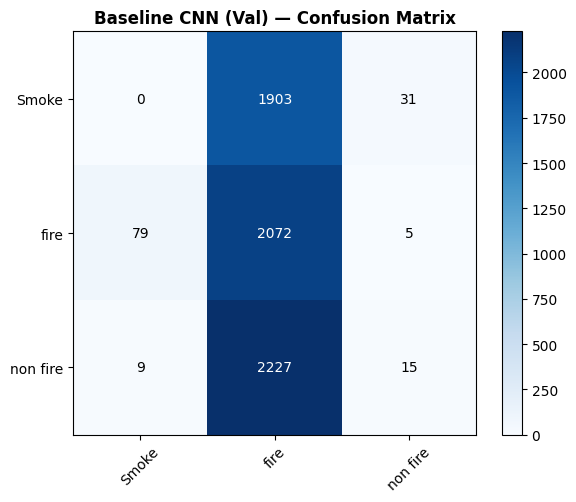

In [26]:
# Baseline CNN — Evaluate on validation set (as required by project spec)
y_true_basic, y_pred_basic = evaluate_model(model_basic, val_ds, name='Baseline CNN (Val)')

In [27]:
# Augmented CNN — Build (With Augmentation + Dropout)
model_aug = models.Sequential([
    layers.Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Augmentation layers (active during training only)
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.15),
    # Conv Block 1
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    # Conv Block 2
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    # Conv Block 3
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),
    # Classification head with Dropout
    layers.Flatten(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model_aug.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model_aug.summary()

c:\Users\user\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\preprocessing\data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_1               │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 187s 236ms/step - accuracy: 0.9664 - loss: 0.1010 - val_accuracy: 0.9633 - val_loss: 0.1410
Epoch 2/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 183s 231ms/step - accuracy: 0.9689 - loss: 0.0971 - val_accuracy: 0.9614 - val_loss: 0.1489
Epoch 3/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 164s 206ms/step - accuracy: 0.9672 - loss: 0.0986 - val_accuracy: 0.9637 - val_loss: 0.1237
Epoch 4/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 166s 210ms/step - accuracy: 0.9694 - loss: 0.0913 - val_accuracy: 0.9664 - val_loss: 0.1246
Epoch 5/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 163s 206ms/step - accuracy: 0.9712 - loss: 0.0863 - val_accuracy: 0.9636 - val_loss: 0.1307
Epoch 6/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 163s 206ms/step - accuracy: 0.9704 - loss: 0.0865 - val_accuracy: 0.9661 - val_loss: 0.1248
Epoch 7/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 167s 210ms/step - accuracy: 0.9706 - loss: 0.0901 - val_accuracy: 0.9663 - val_loss: 0.1207
Epoch 8/30
793/793 ━━━━━━━━━━━━━━━━━━━━ 174s 219ms/step - accuracy: 0.9734 -

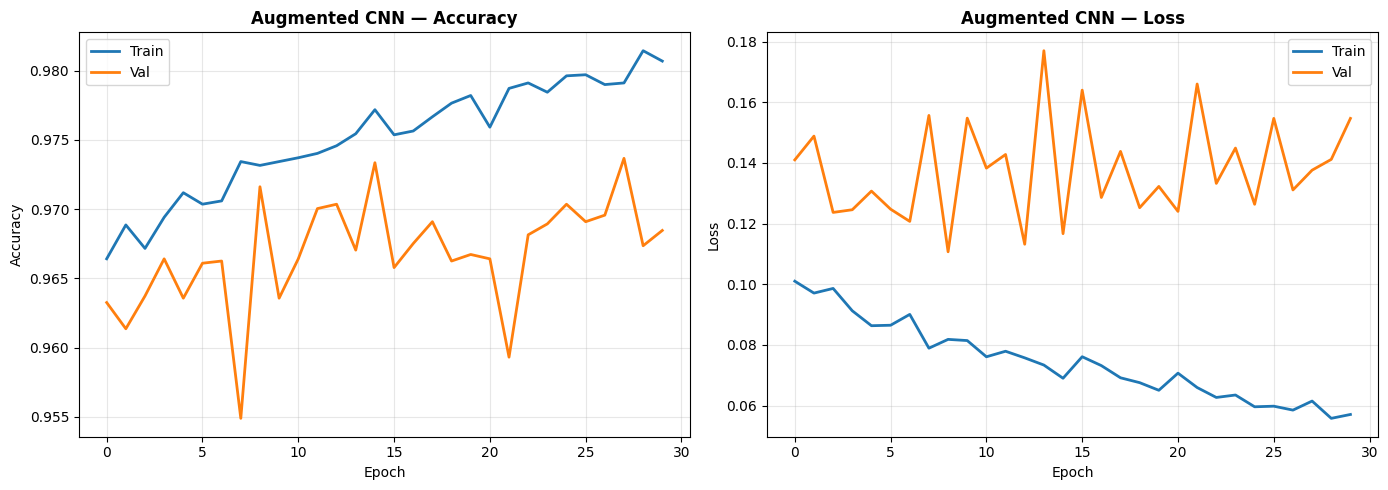


Final Train Acc : 0.9807
Best  Val   Acc : 0.9737
Gap             : 0.0070
 Good generalization


In [16]:
# Augmented CNN — Train
history_aug = model_aug.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)
plot_training_curves(history_aug, title='Augmented CNN')


Augmented CNN (Val) — Classification Report:
              precision    recall  f1-score   support

       Smoke       0.99      0.96      0.97      1934
        fire       0.97      0.97      0.97      2156
    non fire       0.95      0.98      0.97      2251

    accuracy                           0.97      6341
   macro avg       0.97      0.97      0.97      6341
weighted avg       0.97      0.97      0.97      6341



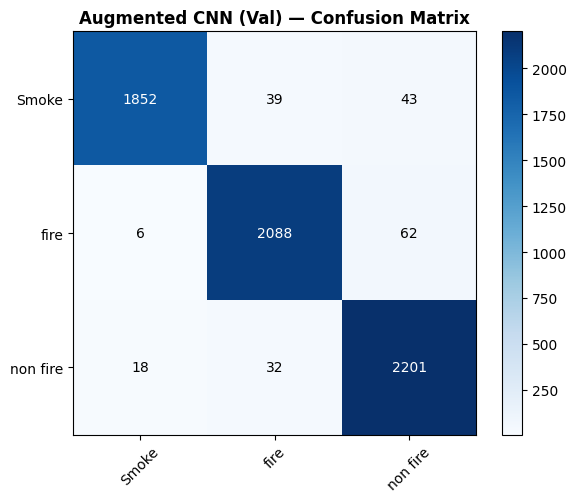

In [23]:
# Augmented CNN — Evaluate on validation set
y_true_aug, y_pred_aug = evaluate_model(model_aug, val_ds, name='Augmented CNN (Val)')


MODEL COMPARISON
        Model Train Acc Val Acc Val F1    Gap
 Baseline CNN    0.9957  0.9696 0.9625 0.0261
Augmented CNN    0.9807  0.9737 0.9685 0.0070


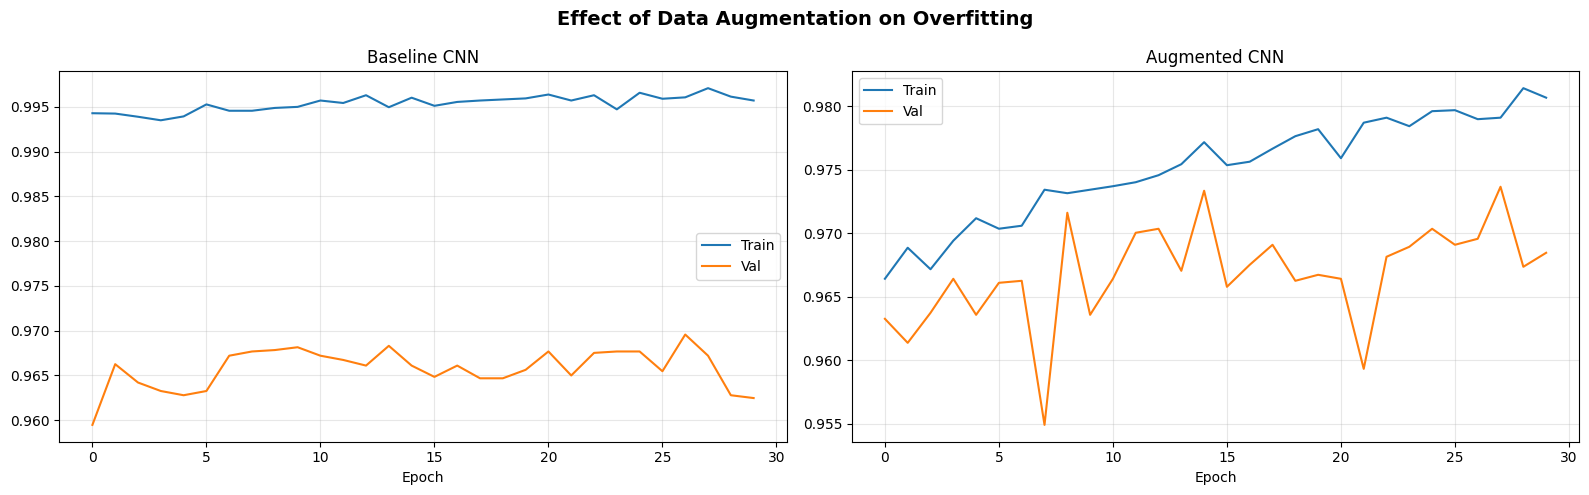

In [18]:
# Model Comparison Table
# Use best val accuracy (not last epoch) to fairly represent each model
basic_train_acc = history_basic.history['accuracy'][-1]
basic_val_acc   = max(history_basic.history['val_accuracy'])
aug_train_acc   = history_aug.history['accuracy'][-1]
aug_val_acc     = max(history_aug.history['val_accuracy'])

basic_f1 = f1_score(y_true_basic, y_pred_basic, average='weighted')
aug_f1   = f1_score(y_true_aug,   y_pred_aug,   average='weighted')

comparison = pd.DataFrame({
    'Model':     ['Baseline CNN', 'Augmented CNN'],
    'Train Acc': [f'{basic_train_acc:.4f}', f'{aug_train_acc:.4f}'],
    'Val Acc':   [f'{basic_val_acc:.4f}',   f'{aug_val_acc:.4f}'],
    'Val F1':    [f'{basic_f1:.4f}',        f'{aug_f1:.4f}'],
    'Gap':       [f'{basic_train_acc - basic_val_acc:.4f}',
                  f'{aug_train_acc  - aug_val_acc:.4f}']
})
print("\n" + "="*60)
print("MODEL COMPARISON")
print(comparison.to_string(index=False))

# Side-by-side accuracy curves
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].plot(history_basic.history['accuracy'],     label='Train')
axes[0].plot(history_basic.history['val_accuracy'], label='Val')
axes[0].set_title('Baseline CNN'); axes[0].set_xlabel('Epoch')
axes[0].legend(); axes[0].grid(True, alpha=0.3)

axes[1].plot(history_aug.history['accuracy'],     label='Train')
axes[1].plot(history_aug.history['val_accuracy'], label='Val')
axes[1].set_title('Augmented CNN'); axes[1].set_xlabel('Epoch')
axes[1].legend(); axes[1].grid(True, alpha=0.3)

plt.suptitle('Effect of Data Augmentation on Overfitting', fontsize=14, fontweight='bold')
plt.tight_layout(); plt.show()

  conv2d_6: output shape = (None, 126, 126, 32)
  conv2d_7: output shape = (None, 61, 61, 64)
  conv2d_8: output shape = (None, 28, 28, 128)


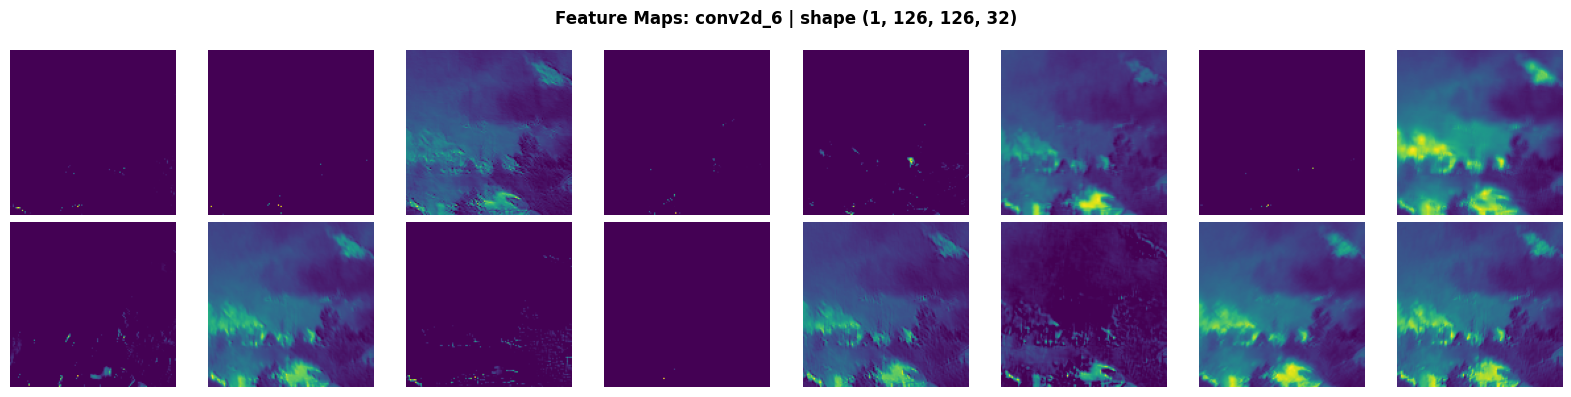

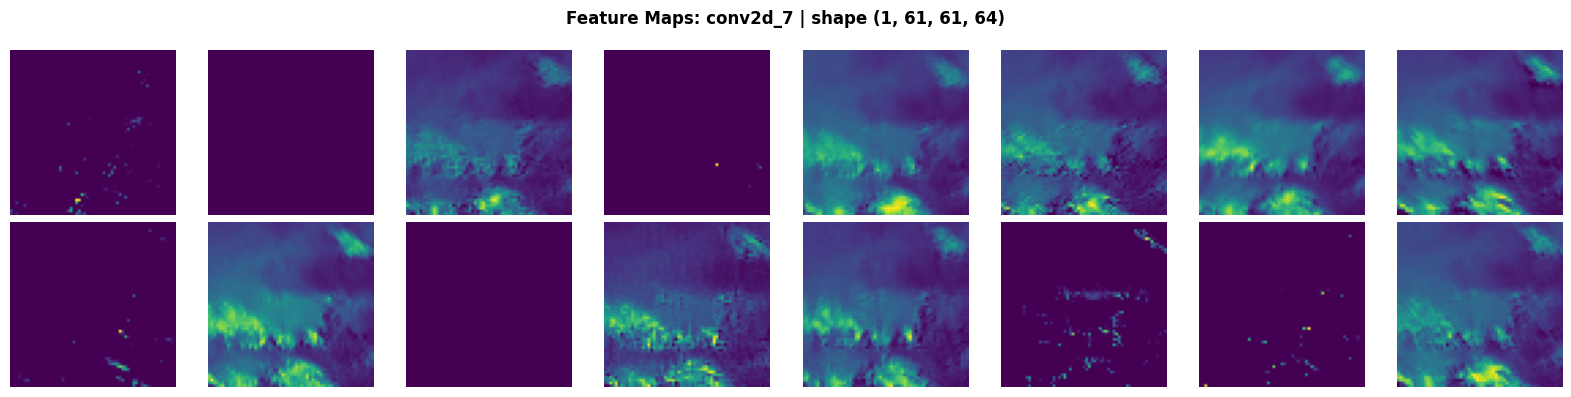

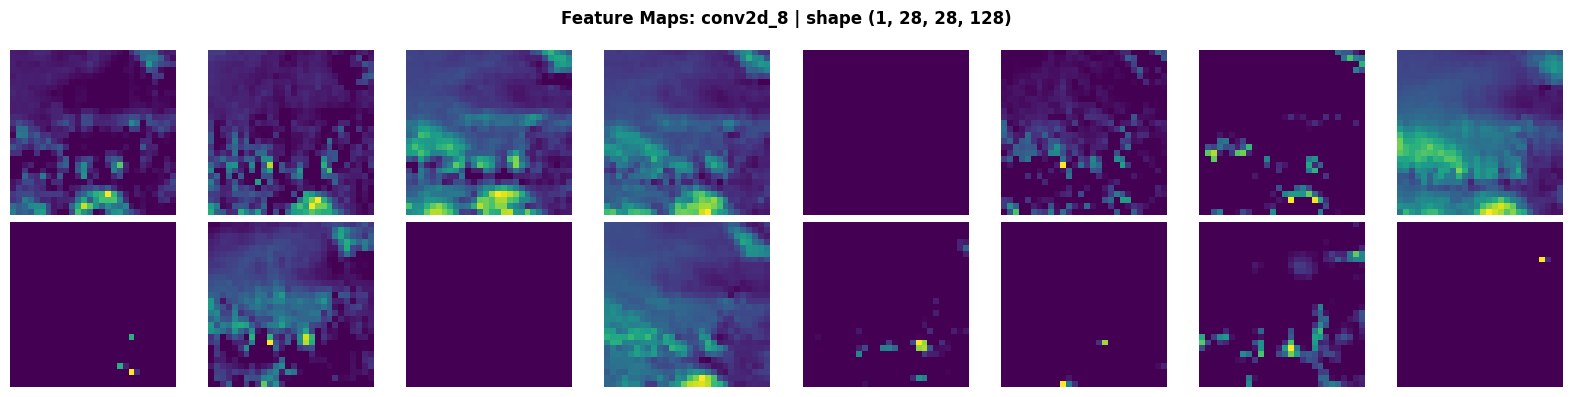

In [28]:
# Visualize CNN Internals — Feature Maps
# Build sub-model that outputs each Conv2D layer's activation
inp = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inp
conv_outputs, conv_names = [], []
for layer in model_basic.layers:
    x = layer(x)
    if isinstance(layer, layers.Conv2D):
        conv_outputs.append(x)
        conv_names.append(layer.name)
        print(f"  {layer.name}: output shape = {x.shape}")

feature_map_model = models.Model(inputs=inp, outputs=conv_outputs)

# Pick one fire image from val set
fire_idx_label = CLASS_NAMES.index('fire')
sample_img = None
for images, labels in val_ds.take(1):
    for i in range(len(labels)):
        if np.argmax(labels[i]) == fire_idx_label:
            sample_img = images[i]
            break
    if sample_img is not None:
        break

feature_maps = feature_map_model.predict(tf.expand_dims(sample_img, 0), verbose=0)

for idx, fmap in enumerate(feature_maps):
    plt.figure(figsize=(16, 4))
    for i in range(min(16, fmap.shape[-1])):
        plt.subplot(2, 8, i+1)
        plt.imshow(fmap[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f"Feature Maps: {conv_names[idx]} | shape {fmap.shape}", fontweight='bold')
    plt.tight_layout(); plt.show()

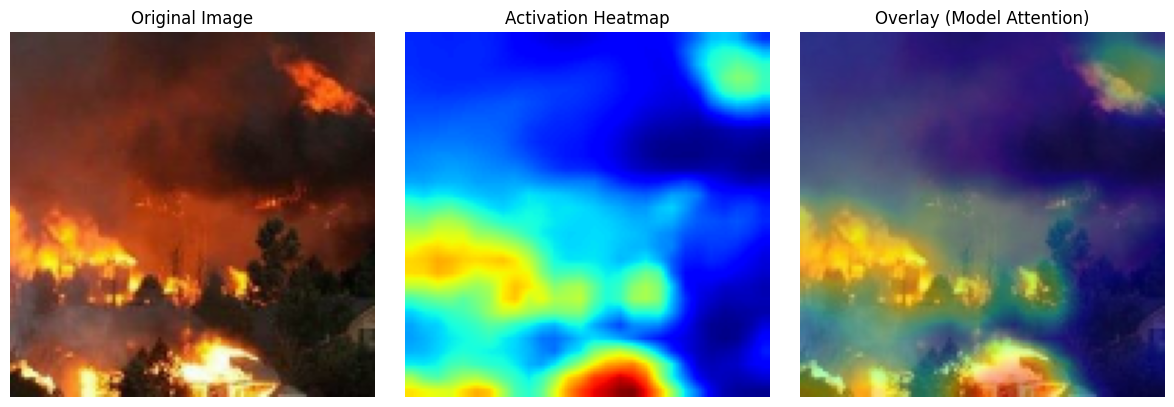

In [29]:
# Activation Heatmap — shows WHERE the model focuses
last_fmap = feature_maps[-1]                         # last conv layer: (1, H, W, 128)
heatmap = np.mean(last_fmap[0], axis=-1)             # average across filters → (H, W)
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
heatmap_resized = tf.image.resize(
    heatmap[..., np.newaxis], (IMG_SIZE, IMG_SIZE)
).numpy().squeeze()

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(sample_img.numpy().astype('uint8'))
plt.title('Original Image'); plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_resized, cmap='jet')
plt.title('Activation Heatmap'); plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sample_img.numpy().astype('uint8'))
plt.imshow(heatmap_resized, cmap='jet', alpha=0.4)
plt.title('Overlay (Model Attention)'); plt.axis('off')

plt.tight_layout(); plt.show()

Misclassified: 4347 / 6341 (68.6%)


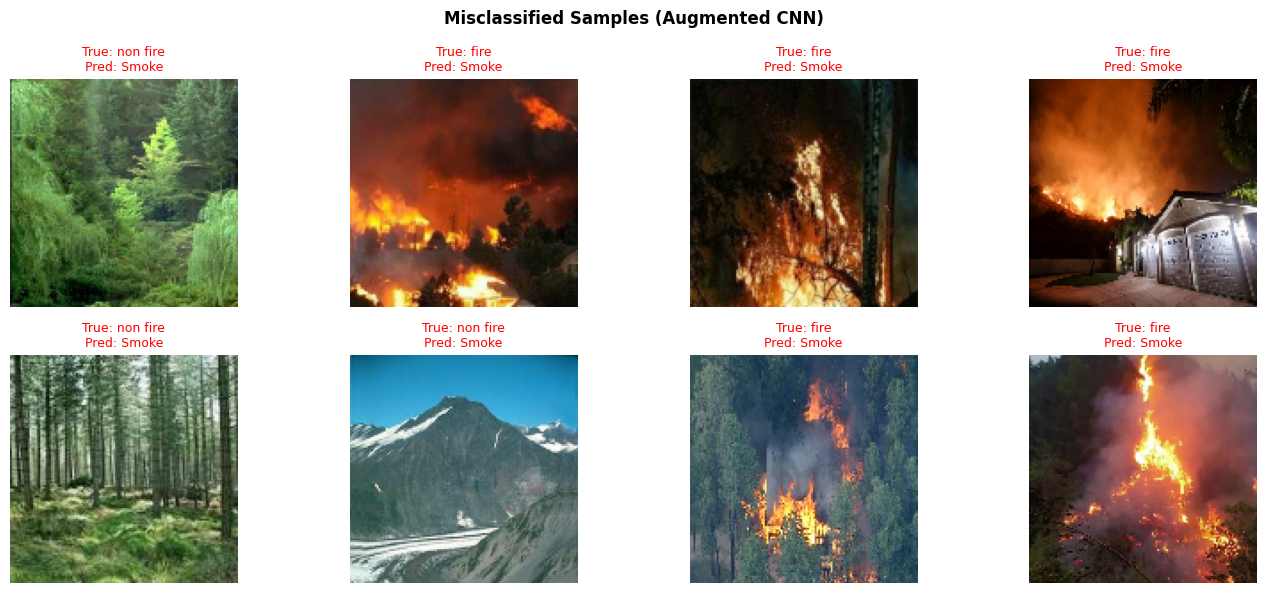


Most confused pairs:
  True=non fire → Pred=Smoke: 2185 times
  True=fire → Pred=Smoke: 2024 times
  True=fire → Pred=non fire: 124 times
  True=Smoke → Pred=non fire: 10 times
  True=non fire → Pred=fire: 4 times


In [30]:
# Misclassified Images — collected in one pass (no double iteration)
all_images, all_true, all_pred = [], [], []
for images, labels in val_ds:
    preds = model_aug.predict(images, verbose=0)
    all_images.extend(images.numpy())
    all_true.extend(np.argmax(labels.numpy(), axis=1))
    all_pred.extend(np.argmax(preds, axis=1))

wrong_idx = [i for i in range(len(all_true)) if all_true[i] != all_pred[i]]
print(f"Misclassified: {len(wrong_idx)} / {len(all_true)} ({len(wrong_idx)/len(all_true)*100:.1f}%)")

plt.figure(figsize=(14, 6))
for i, idx in enumerate(wrong_idx[:8]):
    plt.subplot(2, 4, i+1)
    plt.imshow(all_images[idx].astype('uint8'))
    plt.title(f"True: {CLASS_NAMES[all_true[idx]]}\nPred: {CLASS_NAMES[all_pred[idx]]}",
              fontsize=9, color='red')
    plt.axis('off')
plt.suptitle('Misclassified Samples (Augmented CNN)', fontweight='bold')
plt.tight_layout(); plt.show()

# Most confused class pairs
from collections import Counter
pairs = Counter([
    (CLASS_NAMES[t], CLASS_NAMES[p])
    for t, p in zip(all_true, all_pred) if t != p
])
print("\nMost confused pairs:")
for (true_cls, pred_cls), count in pairs.most_common(5):
    print(f"  True={true_cls} → Pred={pred_cls}: {count} times")